# Hello Model pretrained XCeption Transfer Learning

Perform transfer learning with pretrained XCeption Model

In [1]:
# Prerequisites
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-03-25 14:11:42.850293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742937102.964626    4467 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742937102.995984    4467 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742937103.246333    4467 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742937103.246354    4467 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742937103.246355    4467 computation_placer.cc:177] computation placer alr

### Get Data

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

dataset_size = info.splits["train"].num_examples
print("Flower Dataset size: ", dataset_size)
nr_classes = info.features["label"].num_classes
print("Number of classes: ", nr_classes)
class_names = info.features["label"].names
print("Class names: ", class_names)


/home/jari/MyGitHub/ML_TensorFlow_Keras_Experiments/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 100%|██████████| 1/1 [00:07<00:00,  7.49s/ url]


Dataset tf_flowers downloaded and prepared to /home/jari/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Flower Dataset size:  3670
Number of classes:  5
Class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


I0000 00:00:1742937118.040482    4467 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9474 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:04:00.0, compute capability: 7.0


### Split into train, validation, and test sets

In [3]:
X_test_raw, X_val_raw, X_train_raw = tfds.load("tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True)

### Display first images

2025-03-25 14:12:07.827239: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-25 14:12:08.031896: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-25 14:12:08.036921: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


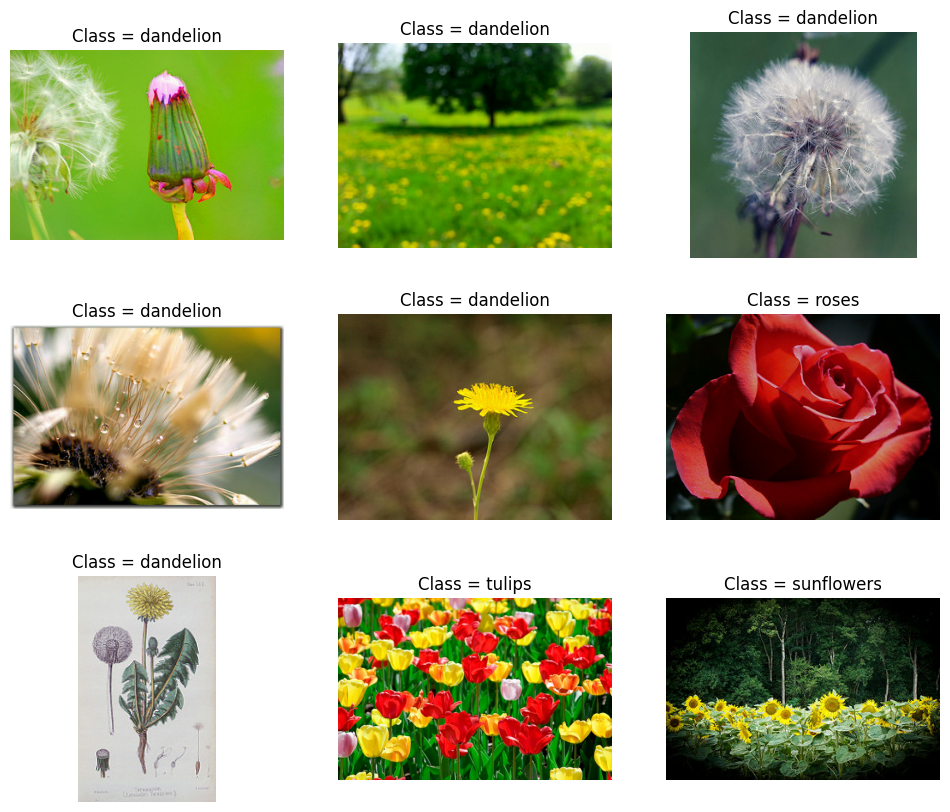

In [4]:
plt.figure(figsize=(12,10))
idx = 0
for image, label in X_val_raw.take(9):
    idx += 1
    plt.subplot(3, 3, idx)
    plt.imshow(image)
    plt.title(f"Class = {class_names[label]}")
    plt.axis("off")

plt.show()

### Resize and batch images

In [5]:
batch_size = 32
preprocess = keras.Sequential([
    keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    keras.layers.Lambda(keras.applications.xception.preprocess_input)
])
X_train = X_train_raw.map(lambda X, y: (preprocess(X), y))
X_train = X_train.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
X_val = X_val_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
X_test = X_test_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

### Create Data Augmentation Layer

In [6]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal", seed=42),
    keras.layers.RandomRotation(factor=0.05, seed=42)
])

### Display first imaged sith Augmentation

2025-03-25 14:12:19.219265: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-25 14:12:20.412310: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


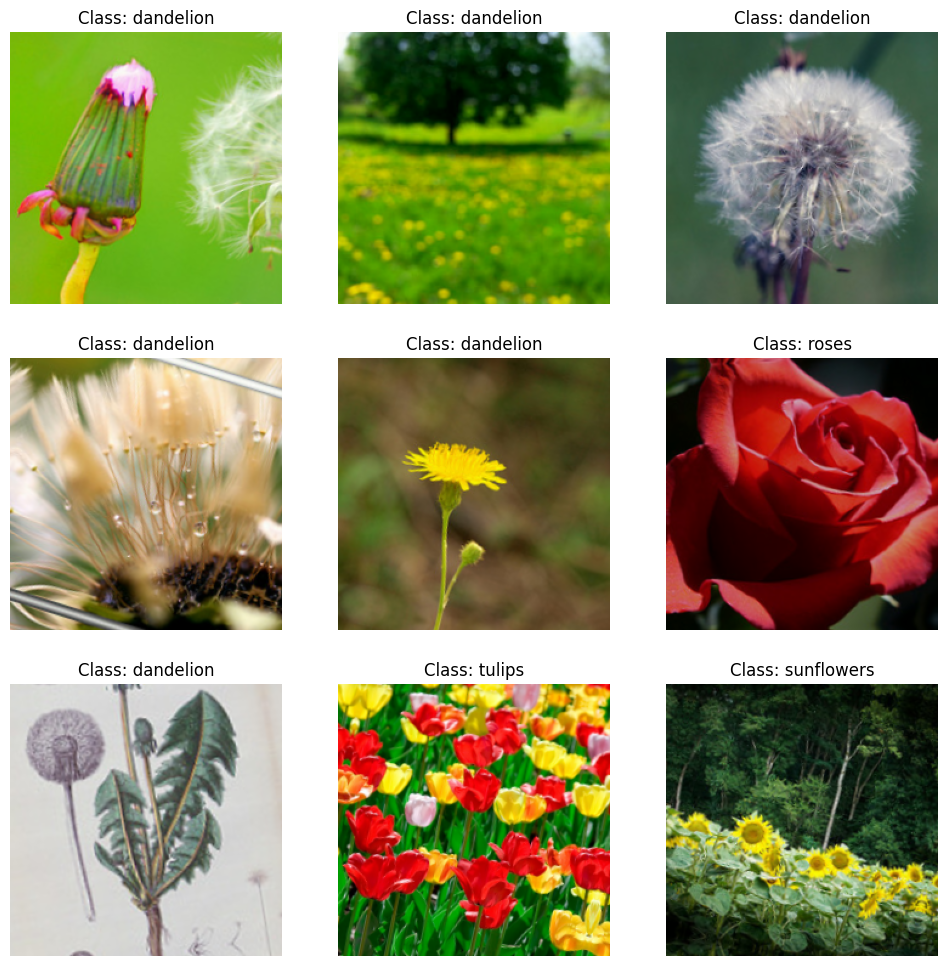

In [7]:

plt.figure(figsize=(12, 12))
for X_batch, y_batch in X_val.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # Rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

### Load Pretrained Model

In [8]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(nr_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Freeze layers, train the model for a few epochs

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, validation_data=X_val, epochs=3)

Epoch 1/3


I0000 00:00:1742937161.033836    4545 service.cc:152] XLA service 0x7c6f8c003de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742937161.033856    4545 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2025-03-25 14:12:41.124257: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742937161.749301    4545 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.2882 - loss: 1.6125

I0000 00:00:1742937165.334170    4545 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.7117 - loss: 0.9331 - val_accuracy: 0.8421 - val_loss: 0.6255
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9219 - loss: 0.3007 - val_accuracy: 0.8711 - val_loss: 0.5990
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9262 - loss: 0.2263 - val_accuracy: 0.8639 - val_loss: 0.5588


- Training 3 epochs on DevManPro CPU took 4m 18s
- Training 3 epochs on NVidia Titan V GPU took 30s

### Unfreeze top layers in base model and train more

In [11]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, validation_data=X_val, epochs=12)

Epoch 1/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - accuracy: 0.8707 - loss: 0.3767 - val_accuracy: 0.8766 - val_loss: 0.6194
Epoch 2/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9808 - loss: 0.0631 - val_accuracy: 0.9129 - val_loss: 0.2890
Epoch 3/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9981 - loss: 0.0135 - val_accuracy: 0.9129 - val_loss: 0.2938
Epoch 4/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9976 - loss: 0.0082 - val_accuracy: 0.9038 - val_loss: 0.3220
Epoch 5/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.9981 - loss: 0.0054 - val_accuracy: 0.9020 - val_loss: 0.2999
Epoch 6/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.9074 - val_loss: 0.3439
Epoch 7/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9975 - loss: 0.0085 - val_accuracy: 0.9056 - val_loss: 0.3163
Epoch 8/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9999 - loss: 0.0037 - val_accu